In [1]:
from transform_ps.etl.data_type import DataFactory

### Inputs

In [2]:
FY = 20
TO_DATE = '9/30/2019'
MARKETING_GOAL = 3250389 + 2754275
TEST_DATA_PATH = '../../../packages/transform_ps/tests/test_data/'

### Setup

In [3]:
factory = DataFactory()

In [4]:
subs = factory.create_data_type('subscriber')
tix = factory.create_data_type('ticket')

In [5]:
tix_filters = tix.type.filters
tix_transform = tix.type.transform

### Import Data

In [6]:
tix.get_data(fys=[FY-1, FY])
subs.get_data(fys=FY)

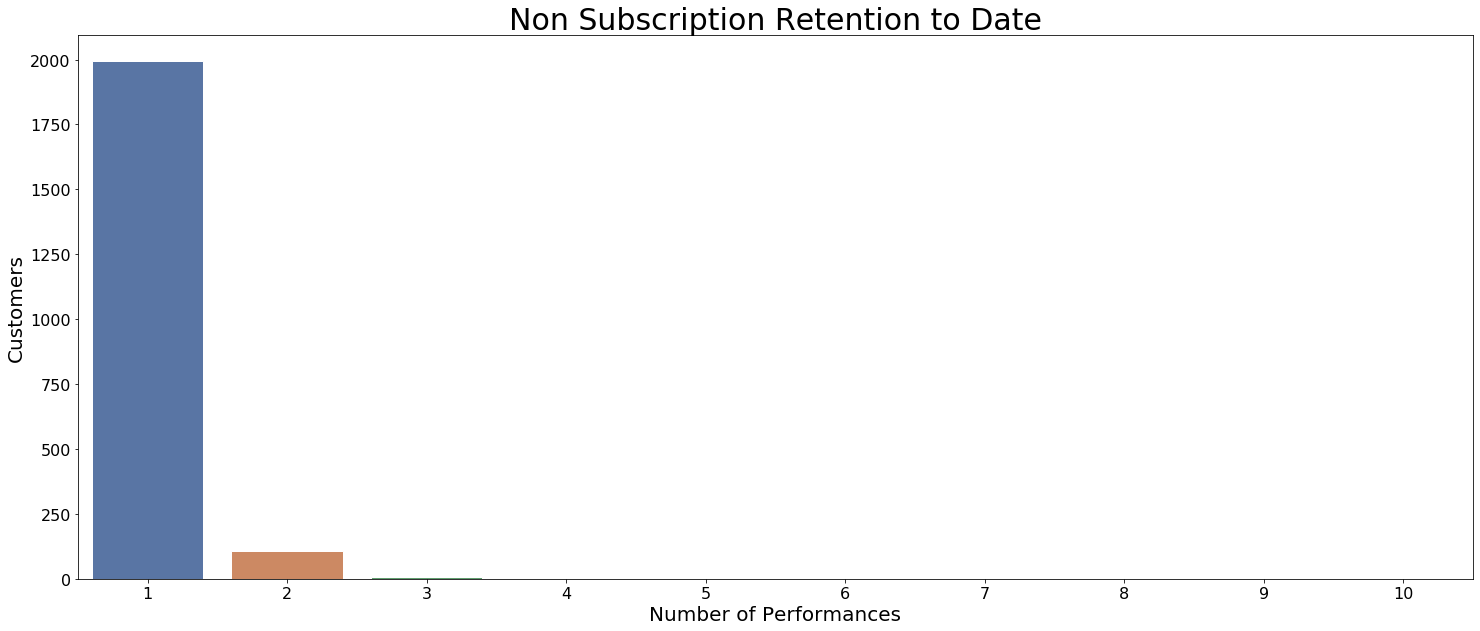

In [7]:
tix.type.ticket_plots.returning_singles_plot(data=tix.working, to_date=TO_DATE, fys=[FY])

### Setup KPIs

In [8]:
kpi_tmp = tix_transform['price_type_group'](data=tix.working)
kpi_tmp = tix_filters['paid'](data=kpi_tmp, column='paid_amt')
kpi_tmp = tix_filters['series'](data=kpi_tmp, series=['Classics', 'Pops'])
kpi_tmp = tix_filters['non_subs'](data=kpi_tmp)

kpi_tmp = kpi_tmp[['summary_cust_id', 'perf_dt']].reset_index(drop=True)
kpi_tmp = kpi_tmp.drop_duplicates()

kpi_tmp = kpi_tmp.groupby('summary_cust_id').agg('count').reset_index()

In [9]:
min_three = tix_filters['min_transactions'](data=kpi_tmp, transaction_col='perf_dt', min_lim=3)

In [10]:
cy_data = tix_filters['fys'](data=tix.working, fys=[FY])
revenue_td = cy_data['paid_amt'].sum()
tix_sold_td = cy_data['paid_amt'].count()
households_td = len(cy_data.summary_cust_id.drop_duplicates())

In [11]:
clx_pops = tix_filters['series'](data=cy_data, series=['Classics', 'Pops'])
clx_pops = tix_filters['before_date'](data=clx_pops, col='perf_dt', to_date=TO_DATE)

In [12]:
avg_tickets_per_concert_td = clx_pops.perf_dt.count() / len(clx_pops.perf_dt.drop_duplicates())

In [13]:
kpis = {
    'capacity sold': round(avg_tickets_per_concert_td / tix.type._capacity * 100, 1),
    '% of goal': round(revenue_td / MARKETING_GOAL * 100, 1),
    'prospects': len(min_three),
    'households': households_td,
    'total subs': subs.type.get_total_pkgs(data=subs.working),
    'tickets_sold': tix_sold_td
}

In [14]:
kpis

{'capacity sold': 64.0,
 '% of goal': 65.5,
 'prospects': 421,
 'households': 7574,
 'total subs': 8367,
 'tickets_sold': 69711}

In [18]:
sum(subs.raw['num_seats'])

8367